<div align='center'>
<h1 style='font-size:38px;'>Creating Disk Images</h1>
<h2 style='font-weight:400;'>Using <code>Image</code> class for disk emission modeling</h2>
<p><em>From grain properties to multi-wavelength disk images</em></p>
</div>

---
**This tutorial covers:**
- Setting up the Image class with grain and star objects
- Defining disk geometry and density profiles
- Computing multi-wavelength images
- Visualizing results with proper scaling


## 1. Imports and setup
We'll use the Image class which combines radiative transfer calculations with geometric disk models.

In [1]:
from pyGrater.stargrains import Grain, Star
from pyGrater.get_image import Image, plot_image
from pyGrater.density import two_power_law
from pyGrater.size_distributions import power_law_distribution
import matplotlib.pyplot as plt
import numpy as np

## 2. Define disk parameters
Set up the physical properties of the circumstellar disk including geometry, density profile, and grain size distribution.

In [2]:
# Disk geometry parameters
reference_radius = 0.1  # AU - reference radius for density profile
scale_height = 0.1 * reference_radius  # Scale height at reference radius

# Density profile parameters (two power-law)
inner_alpha = 10.0      # Inner power-law index
outer_alpha = -4.0      # Outer power-law index  
gamma_exponent = 2.0    # Vertical profile exponent
beta_exponent = 2.0     # Scale height flaring exponent

# Viewing geometry
inclination = 45.0      # Inclination angle (degrees)
position_angle = 30.0   # Position angle (degrees)  
longitude_of_node = 60.0 # Longitude of ascending node (degrees)

# Image parameters
num_pixels_x, num_pixels_y = 256, 256
pixel_size_au = 0.002   # Pixel size in AU

print(f"Disk extends from {reference_radius} AU with scale height {scale_height} AU")
print(f"Image size: {num_pixels_x}×{num_pixels_y} pixels at {pixel_size_au} AU/pixel")
print(f"Field of view: {num_pixels_x * pixel_size_au:.3f} × {num_pixels_y * pixel_size_au:.3f} AU")

Disk extends from 0.1 AU with scale height 0.010000000000000002 AU
Image size: 256×256 pixels at 0.002 AU/pixel
Field of view: 0.512 × 0.512 AU


## 3. Grain size distribution parameters
Define the size distribution of dust grains in the disk.

In [3]:
# Size distribution parameters
grain_size_min = 0.01e-6    # Minimum grain size (meters)
grain_size_max = 3000e-6    # Maximum grain size (meters) 
size_power_index = 3.5      # Power-law index for size distribution
num_size_bins = 400         # Number of size bins for integration

size_params = {
    'a_min': grain_size_min,
    'a_max': grain_size_max, 
    'kappa': size_power_index,
    'N_sizes_integral': num_size_bins
}

print(f"Grain sizes: {grain_size_min*1e6:.2f} - {grain_size_max*1e6:.0f} µm")
print(f"Size distribution: power-law with index {size_power_index}")

Grain sizes: 0.01 - 3000 µm
Size distribution: power-law with index 3.5


## 4. Initialize grain and star objects
Load the optical properties and stellar spectrum needed for flux calculations.

In [4]:
# Create grain and star objects
grain = Grain(redo_Q=False)  # Load precomputed optical efficiencies
star = Star('bPic')          # Load β Pictoris stellar properties and spectrum

print(f"Grain composition: {grain.grain_composition_name}")
print(f"Sublimation temperature: {grain.Tsub} K")
print(f"Star: {star.star_name}, Teff = {star.temp} K, Distance = {star.distance} pc")

General parameters file: /Users/prioletp/PhD/public_codes/pyGrater/pyGrater/parameters/general.yaml
General parameters loaded:
{ 'N_sizes': 2000,
  'N_waves': 2000,
  'N_waves_undersampled': 300,
  'composition': 'aC_ACAR',
  'print_information': True,
  'size_max': 5000,
  'size_min': 0.01,
  'star_name': 'BPic',
  'waves_max': 1500,
  'waves_min': 0.05}
Grain properties:
{ 'Class': 'Native Elements',
  'Density': 1.95,
  'File_par': 'aC_ACAR.txt',
  'File_per1': 'aC_ACAR.txt',
  'File_per2': 'aC_ACAR.txt',
  'Formula': 'C',
  'Full_Name': 'amorphous Carbon, ACAR sample from Zubko et al. 96',
  'Group': 'Carbon',
  'Nickname': 'aC_ACAR',
  'Reference': 'Zubko V. et al 1996, MNRAS, 282, 1321-1329',
  'Subclass': 'non-metals',
  'Tsub': 2000.0,
  'Wav_max': 1984.0,
  'Wav_min': 0.04008,
  'Web': '',
  'Weight_par': 0.333333,
  'Weight_per1': 0.333333,
  'Weight_per2': 0.333333}
aC_ACAR optical tables already exist :
--> Wavelenghts : 2000 values from 5.0e-02 to 1.5e+03 microns
--> Sizes

## 5. Select wavelengths for imaging
Choose wavelengths spanning from optical to far-infrared to see different disk components.

In [5]:
# Wavelengths for multi-band imaging (microns)
wavelengths_for_calc = np.array([0.55, 1.65, 10.257, 60.0, 160.0, 850.0])

print("Selected wavelengths:")
for i, wl in enumerate(wavelengths_for_calc):
    if wl < 5:
        regime = "Near-IR/Optical"
    elif wl < 30:
        regime = "Mid-IR" 
    else:
        regime = "Far-IR/Sub-mm"
    print(f"  {wl:6.3f} µm - {regime}")

Selected wavelengths:
   0.550 µm - Near-IR/Optical
   1.650 µm - Near-IR/Optical
  10.257 µm - Mid-IR
  60.000 µm - Far-IR/Sub-mm
  160.000 µm - Far-IR/Sub-mm
  850.000 µm - Far-IR/Sub-mm


## 6. Create Image object and compute multi-wavelength images
The Image class handles the integration of flux calculations with disk geometry.

In [6]:
# Initialize the Image object
img_obj = Image(grain, star, two_power_law, power_law_distribution, 
               wavelengths_for_calc, num_pixels_x, num_pixels_y, pixel_size_au)

# Combine all parameters for image calculation
image_params = {
    'r0': reference_radius,
    'alphain': inner_alpha, 
    'alphaout': outer_alpha,
    'h0': scale_height,
    'beta': beta_exponent,
    'gamma': gamma_exponent,
    'itilt': inclination,
    'PA': position_angle, 
    'omega': longitude_of_node,
    **size_params  # Add size distribution parameters
}

print("Computing multi-wavelength disk images...")
images = img_obj.get_image(**image_params)
print(f"Generated image cube: {images.shape}")

Loading the thermal distance array from file...
The thermal distances go from 0.059958695533369445 to 6026347.79848734 au
The maximum distance for the temperature calculation is: 6026347.79848734
(2000, 300) (300,)
3.0 2000.0
0.059958695533369445 50.0
Computing multi-wavelength disk images...
Computing multi-wavelength disk images...


Calculating image: 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]

Generated image cube: (6, 256, 256)


## 7. Visualize all wavelengths in a single plot
Display all computed images with a shared intensity scale for comparison.

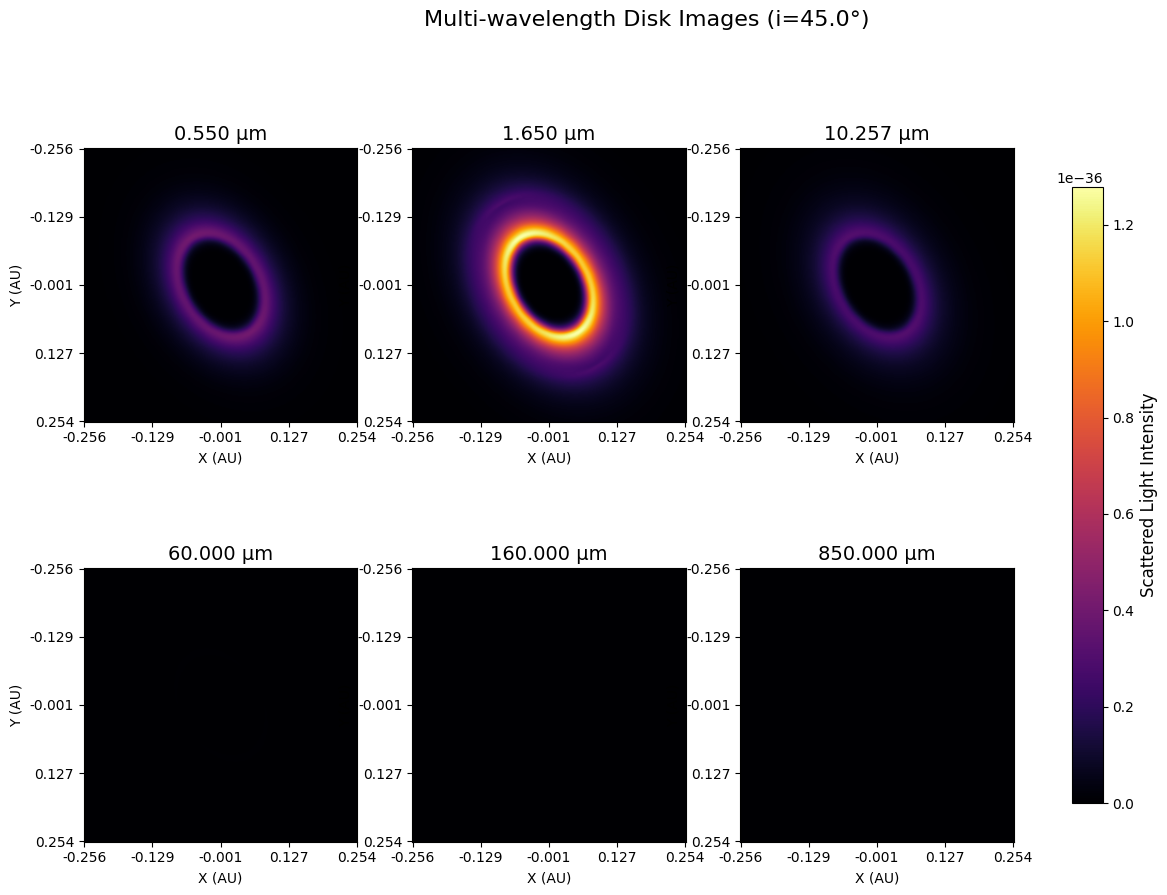

In [8]:
# Plot all wavelengths in a single figure with shared colorbar
n_wavelengths = len(wavelengths_for_calc)
n_cols = 3
n_rows = (n_wavelengths + n_cols - 1) // n_cols  # Ceiling division

# Find global min/max for shared colorbar
vmin = np.min(images)
vmax = np.max(images)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)  # Ensure 2D array for consistency

for i, wave in enumerate(wavelengths_for_calc):
    row = i // n_cols
    col = i % n_cols
    
    im = axes[row, col].imshow(images[i,:,:], cmap='inferno', vmin=vmin, vmax=vmax)
    axes[row, col].set_title(f'{wave:.3f} µm', fontsize=14)
    
    # Set axis labels in AU
    xticks = np.linspace(0, images.shape[2]-1, 5)
    yticks = np.linspace(0, images.shape[1]-1, 5)
    x_labels = (xticks - images.shape[2]//2) * pixel_size_au
    y_labels = (yticks - images.shape[1]//2) * pixel_size_au
    
    axes[row, col].set_xticks(xticks)
    axes[row, col].set_yticks(yticks)
    axes[row, col].set_xticklabels([f'{x:.3f}' for x in x_labels])
    axes[row, col].set_yticklabels([f'{y:.3f}' for y in y_labels])
    axes[row, col].set_xlabel('X (AU)')
    axes[row, col].set_ylabel('Y (AU)')

# Remove empty subplots if any
for j in range(n_wavelengths, n_rows * n_cols):
    row = j // n_cols
    col = j % n_cols
    fig.delaxes(axes[row, col])

# Add shared colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, aspect=20)
cbar.set_label('Scattered Light Intensity', fontsize=12)

plt.suptitle(f'Multi-wavelength Disk Images (i={inclination}°)', fontsize=16)
# plt.tight_layout()
plt.show()

## 8. Analyze individual wavelengths
Look at specific wavelengths to understand the physical processes.

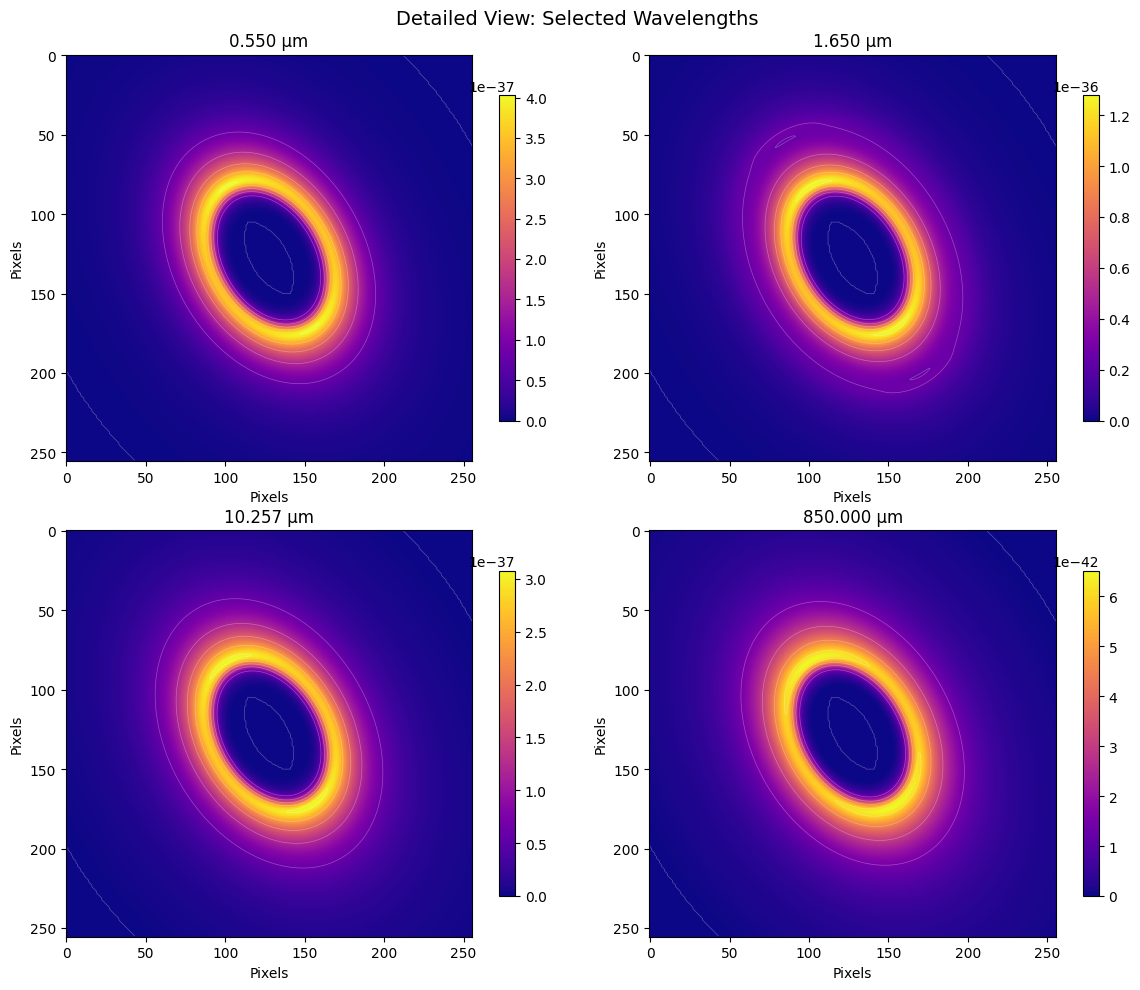

In [9]:
# Plot individual wavelengths with detailed analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Select interesting wavelengths
selected_indices = [0, 1, 2, 5]  # 0.55, 1.65, 10.257, 850 µm
selected_waves = wavelengths_for_calc[selected_indices]

for i, (idx, wave) in enumerate(zip(selected_indices, selected_waves)):
    im = axes[i].imshow(images[idx,:,:], cmap='plasma')
    axes[i].set_title(f'{wave:.3f} µm')
    
    # Add contours to show structure
    axes[i].contour(images[idx,:,:], levels=5, colors='white', alpha=0.3, linewidths=0.5)
    
    plt.colorbar(im, ax=axes[i], shrink=0.8)
    axes[i].set_xlabel('Pixels')
    axes[i].set_ylabel('Pixels')

plt.suptitle('Detailed View: Selected Wavelengths', fontsize=14)
plt.tight_layout()
plt.show()

## 9. Understanding the physics
Each wavelength reveals different aspects of the circumstellar disk structure and dust properties.

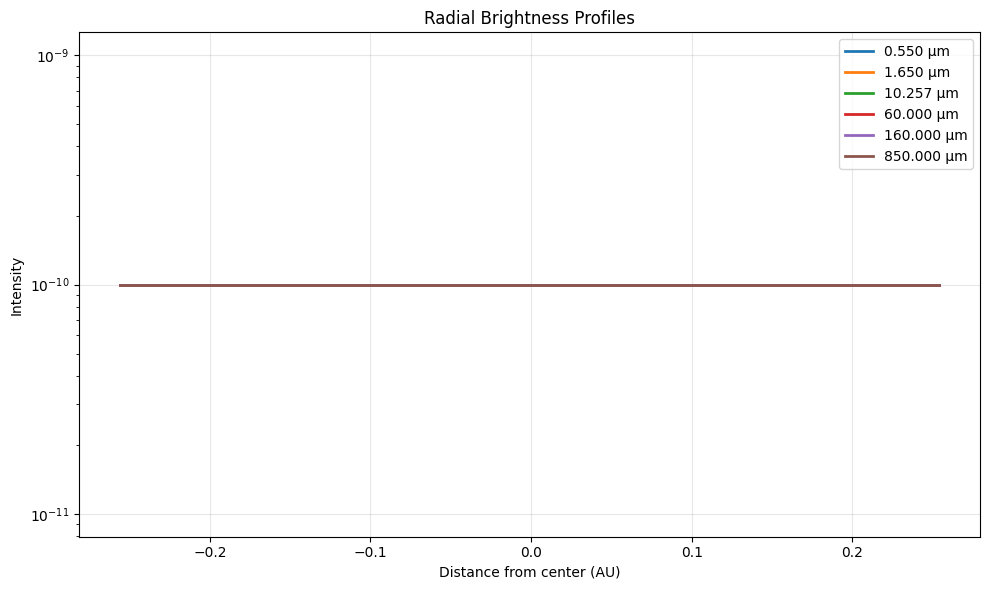

Physical interpretation:
- Shorter wavelengths (0.55, 1.65 µm): Scattered starlight from small grains
- Mid-IR (10.257 µm): Warm dust thermal emission
- Far-IR/sub-mm (60, 160, 850 µm): Cold dust thermal emission from outer disk


In [11]:
# Analyze radial profiles at different wavelengths
center_y, center_x = images.shape[1]//2, images.shape[2]//2

plt.figure(figsize=(10, 6))

for i, wave in enumerate(wavelengths_for_calc):
    # Extract horizontal profile through disk center
    profile = images[i, center_y, :]
    x_au = (np.arange(len(profile)) - center_x) * pixel_size_au
    
    plt.semilogy(x_au, profile + 1e-10, label=f'{wave:.3f} µm', linewidth=2)

plt.xlabel('Distance from center (AU)')
plt.ylabel('Intensity')
plt.title('Radial Brightness Profiles')
plt.legend()
plt.grid(True, alpha=0.3)
# plt.xlim(-0.3, 0.3)
plt.tight_layout()
plt.show()

print("Physical interpretation:")
print("- Shorter wavelengths (0.55, 1.65 µm): Scattered starlight from small grains")
print("- Mid-IR (10.257 µm): Warm dust thermal emission")  
print("- Far-IR/sub-mm (60, 160, 850 µm): Cold dust thermal emission from outer disk")

## 10. Summary
- The `Image` class combines grain optical properties, stellar spectra, and disk geometry
- Multi-wavelength observations reveal different dust populations and temperatures
- Shorter wavelengths probe scattered light from the inner, warmer regions
- Longer wavelengths show thermal emission from cooler, outer disk regions
- Disk inclination and position angle affect the observed morphology
- The flux calculations account for grain size distributions and thermal equilibrium